In [419]:
import time
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
import scipy

In [251]:
temps = pd.read_csv('data/2020.csv.gz', names='station date element value measure_flag quality_flag source_flag obs_time'.split(),
                    dtype={'measure_flag': str, 'quality_flag': str, 'source_flag': str, 'obs_time': str},
                    parse_dates=['date'])

In [252]:
temps = temps[temps.quality_flag.isna()].drop('quality_flag', axis=1)

In [253]:
temp_stations = pd.read_fwf('data/ghcnd-stations.txt', names='station lat lon elev state name gsn hcn wmo_id'.split(),
                            colspecs=[(0, 11), (12, 20), (21, 30), (31, 37), (38, 40), (41, 71), (72, 75), (76, 79), (80, 85)])

In [254]:
temps = temps[temps.element.isin('TMIN TMAX TAVG PRCP'.split())]

In [255]:
def haversine(lat1, lon1, lat2, lon2, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    lat1, lon1 = np.radians([lat1, lon1])
    lat2, lon2 = np.radians([lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [256]:
obs_counts = temps[temps.element=='TAVG'].groupby('station').value.count().rename('obs_count')
obs_counts

station
AE000041196    85
AEM00041194    85
AEM00041217    85
AEM00041218    85
AFM00040938    85
               ..
WZ004455110    16
ZA000067743    10
ZI000067775    83
ZI000067975     7
ZI000067983     1
Name: obs_count, Length: 6582, dtype: int64

In [257]:
# The weather data uses funny country codes...
# COUNTRIES = 'AT BE TR CA PT NO BR AU SE IL CZ MY IE DA EC CL FI'.split()

In [306]:
COUNTRY_COORDS = {
    'US': (40.7789, -73.9692),  # New York City
    'IT': (45.4717, 9.1892),    # Milan
    'CN': (30.6, 114.05),       # Wuhan
    'ES': (40.3, -3.723),       # Madrid
    'DE': (48.13, 11.57),       # Munich
    'FR': (48.86, 2.35),        # Paris
    'IR': (34.64, 50.876),      # Qom
    'UK': (51.507, -0.128),     # London
    'CH': (46.00, 8.95),        # Lugano
    'KR': (35.87, 128.6),       # Daegu
    'NL': (51.55, 5.08),        # Tilburg
    'AT': (48.2, 16.37),        # Vienna
    'TR': (41.01, 28.955),      # Istanbul chosen arbitrarily (no clear which cities are epicenters)
    'CA': (45.51, -73.56),      # Montreal
    'PT': (38.73, -9.15),       # Lisbon
    'NO': (59.91, 10.75),       # Oslo,
    'AU': (-37.81, 144.96),     # Melbourne
    'IL': (31.78, 35.22),       # Jerusalem
    'BR': (-23.55, -46.63),     # São Paulo
    'SE': (59.33, 18.07),       # Stockholm
    'CZ': (50.08, 14.42),       # Prague
    'IE': (53.35, -6.27),       # Dublin
    'MY': (3.15, 101.70),       # Kuala Lumpur
    'DE': (55.68, 12.57),       # Copenhagen
    'CL': (-33.45, -70.67),     # Santiago
    'LU': (49.61, 6.13),        # Luxemburg City
    'EC': (-2.18, -79.88),      # Guayaquil
    'JP': (35.69, 139.69),      # Tokyo
    'PL': (52.23, 20.02),       # Warsaw
    'RO': (44.43, 26.10),       # Bucharest
    'PK': (24.86, 67.01),       # Karachi
    'RU': (55.76, 37.62),       # Moscow
    'TH': (13.75, 100.49),      # Bangkok
    'SA': (26.56, 50.00),       # Qatif
    'ZA': (-26.20, 28.05),      # Johannesburg
    'FI': (60.1667, 24.95),     # Helsinki
}

In [309]:
STATIONS = {'US': 'USW00014732',   # New York Laguardia AP,
            'IT': 'ITM00016088',   # Ghedi
            'CN': 'CHM00057494',   # Wuhan
            'ES': 'SPE00120296',   # Madrid Getafe
            'DE': 'GMM00010870',   # Schwaigermoos, near Munich
            'FR': 'FR000007150',   # Paris Le Bourget
            'IR': 'IRM00040785',   # Kashan, near Qom
            'UK': 'UKM00003772',   # London Heathrow
            'CH': 'SZ000009480',   # Lugano
            'KR': 'KSM00047138',   # Pohang, near Daegu
            'NL': 'NLM00006260',   # de Bilt, near Tilburg
            'AT': 'AU000005901',   # Wien
            'TR': 'TUM00017064',   # Istanbul Bolge (Kartal),
            'CA': 'CA007024745',   # McTavish
            'PT': 'PO000008535',   # Lisboa Geofisica
            'NO': 'NOM00001492',   # Oslo Blindern,
            'AU': 'ASN00087031',   # Laverton RAAF
            'IL': 'ISM00040180',   # Ben Gurion
            'BR': 'BR00E3-0520',   # São Paulo aeroport
            'SE': 'SWM00002589',   # Gotska Sandön A
            'CZ': 'EZM00011520',   # Praha-Libus
            'IE': 'EI000003969',   # Dublin Phoenix Park
            'MY': 'MYM00048647',   # Sultan Abdul Aziz Shah Intl
            'CL': 'CIM00085577',   # Quinta Normal
            'LU': 'LU000006590',   # Luxembourg airport
            'EC': 'PEM00084370',   # Pedro Canga
            'JP': 'JA000047662',   # Tokyo
            'PL': 'PLM00012375',   # Okecie
            'RO': 'ROE00108889',   # Bucuresti-Baneasa
            'PK': 'PKM00041780',   # Jinnah Intl
            'RU': 'RSM00027612',   # Moscow
            'TH': 'TH000048455',   # Bangkok metropolis
            'SA': 'SAW00032502',   # Dhahran
            'ZA': 'SFM00068368',   # Johannesburg Intl
            'FI': 'FIE00142101',   # Helsinki Ilmala,
           }
assert len(set(STATIONS.values())) == len(set(STATIONS)), 'Two countries map to same station; currently this breaks our logic'

In [310]:
def find_nearest():
    for country, (lat, lon) in COUNTRY_COORDS.items():
        if country in STATIONS:
            continue
        stations = temp_stations.copy()
        stations['dist'] = haversine(lat, lon, stations.lat, stations.lon)
        stations = stations.sort_values('dist')
        stations = stations.merge(obs_counts, on='station').set_index('station')
        print(f'Nearest to {country}:')
        print(stations['obs_count dist elev name'.split()].iloc[:10])
        print()
        
find_nearest()

In [311]:
print('#TAVG observations on stations:')
tavgs = temps[temps.element=='TAVG']
tavgs = tavgs[tavgs.station.isin(STATIONS.values())]
print(tavgs.groupby('station').count().value)

#TAVG observations on stations:
station
ASN00087031    84
AU000005901    85
BR00E3-0520    85
CA007024745    85
CHM00057494    85
CIM00085577    85
EI000003969    85
EZM00011520    85
FIE00142101    85
FR000007150    85
GMM00010870    85
IRM00040785    85
ISM00040180    85
ITM00016088    85
JA000047662    85
KSM00047138    85
LU000006590    85
MYM00048647    85
NLM00006260    85
NOM00001492    85
PEM00084370    85
PKM00041780    85
PLM00012375    85
PO000008535    85
ROE00108889    85
RSM00027612    85
SAW00032502    85
SFM00068368    84
SPE00120296    85
SWM00002589    85
SZ000009480    85
TH000048455    85
TUM00017064    85
UKM00003772    85
USW00014732    84
Name: value, dtype: int64


In [312]:
temps.station = temps.station.map({v: k for k, v in STATIONS.items()})

In [313]:
# The data has tenths of degrees, tenths of millimeters
temps.value /= 10

In [314]:
temps = pd.pivot_table(temps, index=['date'], columns=['element', 'station'], values='value')

In [315]:
covid = pd.read_csv('data/COVID-19-geographic-disbtribution-worldwide.csv',
                   parse_dates=['dateRep'], na_values=[''], keep_default_na=False).rename(
    columns={'countryterritoryCode': 'country', 'popData2018': 'population'})

In [316]:
covid['date'] = pd.to_datetime(covid[['day', 'month', 'year']])

In [317]:
covid

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,country,population,date
0,2020-03-28,28,3,2020,16,1,Afghanistan,AF,AFG,37172386.0,2020-03-28
1,2020-03-27,27,3,2020,0,0,Afghanistan,AF,AFG,37172386.0,2020-03-27
2,2020-03-26,26,3,2020,33,0,Afghanistan,AF,AFG,37172386.0,2020-03-26
3,2020-03-25,25,3,2020,2,0,Afghanistan,AF,AFG,37172386.0,2020-03-25
4,2020-03-24,24,3,2020,6,1,Afghanistan,AF,AFG,37172386.0,2020-03-24
...,...,...,...,...,...,...,...,...,...,...,...
7315,2020-03-25,25,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0,2020-03-25
7316,2020-03-24,24,3,2020,0,1,Zimbabwe,ZW,ZWE,14439018.0,2020-03-24
7317,2020-03-23,23,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0,2020-03-23
7318,2020-03-22,22,3,2020,1,0,Zimbabwe,ZW,ZWE,14439018.0,2020-03-22


In [318]:
covid = covid['date cases deaths country population geoId'.split()]

In [319]:
covid = covid.pivot(index='date', columns='geoId')

In [320]:
covid = covid.sort_values(by='date')

The cases and deaths columns in the dataset contain new cases/deaths, not the cumulative count

In [321]:
covid

cases                                                        ...  \
geoId         AD    AE    AF   AG   AI    AL    AM   AO     AR      AT  ...   
date                                                                    ...   
2019-12-31   NaN   0.0   0.0  NaN  NaN   NaN   0.0  NaN    NaN     0.0  ...   
2020-01-01   NaN   0.0   0.0  NaN  NaN   NaN   0.0  NaN    NaN     0.0  ...   
2020-01-02   NaN   0.0   0.0  NaN  NaN   NaN   0.0  NaN    NaN     0.0  ...   
2020-01-03   NaN   0.0   0.0  NaN  NaN   NaN   0.0  NaN    NaN     0.0  ...   
2020-01-04   NaN   0.0   0.0  NaN  NaN   NaN   0.0  NaN    NaN     0.0  ...   
...          ...   ...   ...  ...  ...   ...   ...  ...    ...     ...  ...   
2020-03-24  20.0  45.0   6.0  0.0  NaN  11.0   4.0  0.0   35.0   855.0  ...   
2020-03-25  31.0  50.0   2.0  2.0  NaN  23.0  71.0  0.0   86.0   796.0  ...   
2020-03-26  24.0  85.0  33.0  0.0  NaN  23.0  25.0  0.0  115.0   606.0  ...   
2020-03-27  36.0   0.0   0.0  4.0  2.0  28.0  39.0  1.0   87.0  1141.0  ...   
2020-03-28  43.0  72.0  16.0  0.0  0.0  12.0  43.0  1.0  101.0   668.0  ...   

           population                                                       \
geoId              VA        VC          VE       VG        VI          VN   
date                                                                         
2019-12-31        NaN       NaN         NaN      NaN       NaN  95540395.0   
2020-01-01        NaN       NaN         NaN      NaN       NaN  95540395.0   
2020-01-02        NaN       NaN         NaN      NaN       NaN  95540395.0   
2020-01-03        NaN       NaN         NaN      NaN       NaN  95540395.0   
2020-01-04        NaN       NaN         NaN      NaN       NaN  95540395.0   
...               ...       ...         ...      ...       ...         ...   
2020-03-24     1000.0       NaN  28870195.0      NaN  106977.0  95540395.0   
2020-03-25     1000.0  110210.0  28870195.0      NaN  106977.0  95540395.0   
2020-03-26     1000.0  110210.0  28870195.0      NaN  106977.0  95540395.0   
2020-03-27     1000.0  110210.0  28870195.0  29802.0  106977.0  95540395.0   
2020-03-28     1000.0  110210.0  28870195.0  29802.0  106977.0  95540395.0   

                                                           
geoId              XK          ZA          ZM          ZW  
date                                                       
2019-12-31        NaN         NaN         NaN         NaN  
2020-01-01        NaN         NaN         NaN         NaN  
2020-01-02        NaN         NaN         NaN         NaN  
2020-01-03        NaN         NaN         NaN         NaN  
2020-01-04        NaN         NaN         NaN         NaN  
...               ...         ...         ...         ...  
2020-03-24  1845300.0  57779622.0  17351822.0  14439018.0  
2020-03-25  1845300.0  57779622.0  17351822.0  14439018.0  
2020-03-26  1845300.0  57779622.0  17351822.0  14439018.0  
2020-03-27  1845300.0  57779622.0  17351822.0  14439018.0  
2020-03-28  1845300.0  57779622.0  17351822.0  14439018.0  

[89 rows x 784 columns]

In [322]:
covid = covid.join(covid[['cases']].cumsum().rename(columns={'cases': 'cases_cum'}))
covid = covid.join(covid[['deaths']].cumsum().rename(columns={'deaths': 'deaths_cum'}))

In [323]:
covid

cases                                                        ...  \
geoId         AD    AE    AF   AG   AI    AL    AM   AO     AR      AT  ...   
date                                                                    ...   
2019-12-31   NaN   0.0   0.0  NaN  NaN   NaN   0.0  NaN    NaN     0.0  ...   
2020-01-01   NaN   0.0   0.0  NaN  NaN   NaN   0.0  NaN    NaN     0.0  ...   
2020-01-02   NaN   0.0   0.0  NaN  NaN   NaN   0.0  NaN    NaN     0.0  ...   
2020-01-03   NaN   0.0   0.0  NaN  NaN   NaN   0.0  NaN    NaN     0.0  ...   
2020-01-04   NaN   0.0   0.0  NaN  NaN   NaN   0.0  NaN    NaN     0.0  ...   
...          ...   ...   ...  ...  ...   ...   ...  ...    ...     ...  ...   
2020-03-24  20.0  45.0   6.0  0.0  NaN  11.0   4.0  0.0   35.0   855.0  ...   
2020-03-25  31.0  50.0   2.0  2.0  NaN  23.0  71.0  0.0   86.0   796.0  ...   
2020-03-26  24.0  85.0  33.0  0.0  NaN  23.0  25.0  0.0  115.0   606.0  ...   
2020-03-27  36.0   0.0   0.0  4.0  2.0  28.0  39.0  1.0   87.0  1141.0  ...   
2020-03-28  43.0  72.0  16.0  0.0  0.0  12.0  43.0  1.0  101.0   668.0  ...   

           deaths_cum                                               
geoId              VA   VC   VE   VG   VI   VN   XK   ZA   ZM   ZW  
date                                                                
2019-12-31        NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  
2020-01-01        NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  
2020-01-02        NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  
2020-01-03        NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  
2020-01-04        NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  
...               ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
2020-03-24        0.0  NaN  0.0  NaN  0.0  0.0  1.0  0.0  0.0  1.0  
2020-03-25        0.0  0.0  0.0  NaN  0.0  0.0  1.0  0.0  0.0  1.0  
2020-03-26        0.0  0.0  0.0  NaN  0.0  0.0  1.0  0.0  0.0  1.0  
2020-03-27        0.0  0.0  1.0  0.0  0.0  0.0  1.0  2.0  0.0  1.0  
2020-03-28        0.0  0.0  1.0  0.0  0.0  0.0  1.0  2.0  0.0  1.0  

[89 rows x 1176 columns]

In [324]:
covid.cases_cum / covid.population

geoId,AD,AE,AF,AG,AI,AL,AM,AO,AR,AT,...,VA,VC,VE,VG,VI,VN,XK,ZA,ZM,ZW
date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
2020-01-01,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
2020-01-02,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
2020-01-03,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
2020-01-04,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-24,0.001727,0.000021,0.000001,0.000010,NaN,0.000035,0.000066,6.491449e-08,0.000007,0.000507,...,0.001,NaN,0.000003,NaN,0.000159,0.000001,0.000033,0.000007,1.728925e-07,1.385136e-07
2020-03-25,0.002130,0.000026,0.000001,0.000031,NaN,0.000043,0.000090,6.491449e-08,0.000009,0.000597,...,0.001,0.000009,0.000003,NaN,0.000159,0.000001,0.000034,0.000010,1.728925e-07,1.385136e-07
2020-03-26,0.002441,0.000035,0.000002,0.000031,NaN,0.000051,0.000098,6.491449e-08,0.000011,0.000666,...,0.001,0.000009,0.000004,NaN,0.000159,0.000002,0.000038,0.000012,6.915700e-07,2.077704e-07


In [325]:
MIN_CASES = 30

In [326]:
cases_cum = covid.cases_cum[covid.cases_cum >= MIN_CASES]
cases_cum = cases_cum[cases_cum.first_valid_index():]

In [327]:
def crop_series(ser):
    ser = ser[ser >= MIN_CASES]
    return ser[ser.first_valid_index():]

def plot_log(ser, label=None):
    ser[ser.first_valid_index():].plot(logy=True, label=label)

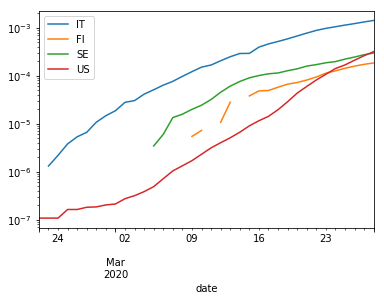

In [328]:
plot_log(cases_cum.IT/covid.population.IT)
plot_log(cases_cum.FI/covid.population.FI)
plot_log(cases_cum.SE/covid.population.SE)
plot_log(cases_cum.US/covid.population.US)

plt.legend()

In [329]:
NUM_DIFFS_TO_USE = 4
PRED_VARS = [f'x{n}' for n in range(1, NUM_DIFFS_TO_USE+1)]

In [330]:
shifted = [cases_cum] + [cases_cum.shift(freq=f'{days}d') for days in range(1, NUM_DIFFS_TO_USE+2)]
pred_data = pd.concat([cases_cum] + [a/b for a, b in zip(shifted, shifted[1:])],
                      keys=['cases_cum', 'y'] + PRED_VARS,
                      axis=1).stack().dropna()

In [331]:
pred_data.max()

cases_cum    104686.000000
y                 2.700000
x1                2.700000
x2                2.700000
x3                6.032258
x4                6.032258
dtype: float64

In [332]:
pred_data

cases_cum         y        x1        x2        x3        x4
date       geoId                                                             
2020-01-08 CN          59.0  1.000000  1.000000  1.000000  1.340909  1.000000
2020-01-09 CN          59.0  1.000000  1.000000  1.000000  1.000000  1.340909
2020-01-10 CN          59.0  1.000000  1.000000  1.000000  1.000000  1.000000
2020-01-11 CN          59.0  1.000000  1.000000  1.000000  1.000000  1.000000
2020-01-12 CN          59.0  1.000000  1.000000  1.000000  1.000000  1.000000
...                     ...       ...       ...       ...       ...       ...
2020-03-28 UZ         104.0  1.253012  1.276923  1.181818  1.122449  1.065217
           VE         119.0  1.112150  1.009434  1.164835  1.083333  2.333333
           VN         169.0  1.104575  1.033784  1.104478  1.089431  1.042373
           XK          86.0  1.088608  1.112676  1.126984  1.032787  1.967742
           ZA        1170.0  1.262136  1.307475  1.272890  1.385572  1.467153

[1351 rows x 6 columns]

In [333]:
# regr = Pipeline([('log', FunctionTransformer(np.log, inverse_func=np.exp)), ('linear', LinearRegression())])
regr = LinearRegression()

In [334]:
regr.fit(pred_data[PRED_VARS], pred_data.y.to_numpy().reshape(-1, 1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [335]:
pred_data['y_pred'] = regr.predict(pred_data[PRED_VARS])
pred_data['y_residual'] = pred_data.y - pred_data.y_pred
pred_data['cases_cum_pred'] = pred_data.cases_cum / pred_data.y * pred_data.y_pred

In [336]:
pred_data = pred_data.unstack()

In [337]:
def plot_pred(data, country):
    plot_log(pred_data.cases_cum[country], f'{country} real')
    plot_log(pred_data.cases_cum_pred[country], f'{country} pred')
    plt.legend()
    print(f'log-loss: {(pred_data.y[country]-pred_data.y_pred[country]).pow(2).mean()}')

log-loss: 0.01145486776110168


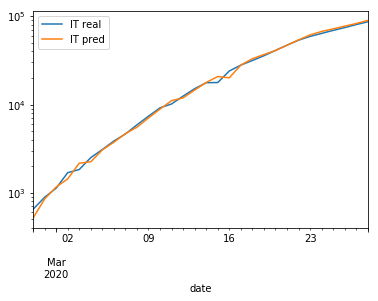

In [338]:
plot_pred(pred_data, 'IT')

log-loss: 0.0019167593535923577


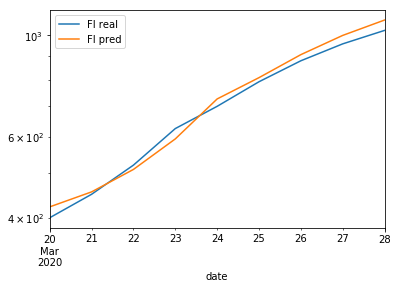

In [339]:
plot_pred(pred_data, 'FI')

log-loss: 0.005548426600528466


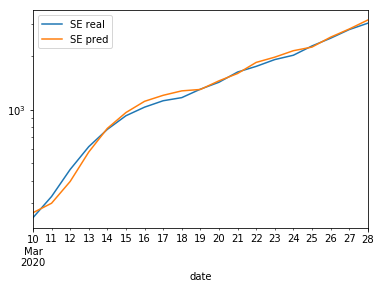

In [340]:
plot_pred(pred_data, 'SE')

log-loss: 0.040433003937891024


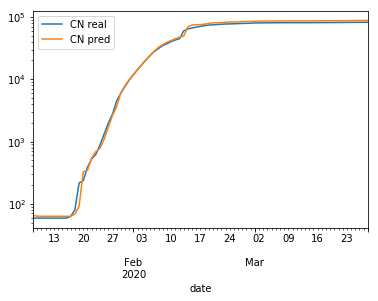

In [341]:
plot_pred(pred_data, 'CN')

In [342]:
pred_data.y_residual -= pred_data.y_residual.mean()

In [343]:
pred_data.y_residual

geoId,CN,JPG11668,SG,TH,JP,KR,US,IT,IR,TW,...,DO,KH,LI,UZ,TT,UA,AF,CU,NG,XK
date,,,,,,,,,,,,,,,,,,,,,
2020-01-08,-0.085881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,-0.054161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-10,-0.050046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-11,-0.050046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-12,-0.050046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-24,-0.049565,NaN,0.037956,-0.140449,-0.028751,-0.039393,-0.002137,-0.071183,-0.034690,0.070493,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-25,-0.049598,NaN,0.014376,-0.053990,-0.003682,-0.035753,-0.119990,-0.057017,-0.025168,-0.005962,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-26,-0.049288,NaN,-0.065248,-0.002462,-0.002160,-0.035784,-0.023285,-0.055572,-0.018172,-0.023306,...,-0.024116,-0.023765,-0.000260,-0.047044,NaN,NaN,NaN,NaN,NaN,NaN


In [344]:
temps

element    PRCP                                               ... TMIN        \
station      AT   AU   BR   CA   CH   CL   CN   CZ   DE   EC  ...   PL    PT   
date                                                          ...              
2020-01-01  NaN  0.0  0.0  3.0  0.0  0.0  NaN  0.0  0.0  0.3  ...  0.8   NaN   
2020-01-02  NaN  0.0  1.0  0.0  0.0  0.0  NaN  0.0  0.0  NaN  ...  NaN   8.0   
2020-01-03  NaN  0.0  4.1  0.0  0.0  0.0  1.5  0.0  1.0  NaN  ...  NaN  10.8   
2020-01-04  NaN  0.0  0.0  1.2  0.0  0.0  0.3  0.3  1.0  NaN  ...  NaN   NaN   
2020-01-05  NaN  1.6  1.0  0.2  0.0  0.0  3.8  0.5  0.2  NaN  ...  NaN   NaN   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   
2020-03-22  NaN  NaN  0.0  0.0  NaN  0.0  NaN  1.0  NaN  NaN  ... -2.3   9.5   
2020-03-23  NaN  NaN  0.0  4.8  NaN  0.0  NaN  0.0  NaN  NaN  ... -4.3  11.5   
2020-03-24  NaN  NaN  0.0  2.3  NaN  0.0  0.0  0.0  NaN  NaN  ...  NaN   NaN   
2020-03-25  NaN  NaN  0.0  0.2  NaN  2.0  4.3  0.0  NaN  NaN  ... -4.1   NaN   
2020-03-26  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   NaN   

element                                               
station      RO   RU   SE    TH   TR   UK   US    ZA  
date                                                  
2020-01-01  NaN  NaN  3.0  25.3  NaN  1.7  1.7   NaN  
2020-01-02 -7.5 -1.9  4.9  25.0  NaN  6.2  1.1  15.0  
2020-01-03  NaN  NaN  4.2  25.0  2.9  NaN  7.2   NaN  
2020-01-04 -7.0 -1.3  2.4  25.2  NaN  2.2  5.0   NaN  
2020-01-05  NaN -1.6  0.7  25.3  3.5  NaN  2.2  15.1  
...         ...  ...  ...   ...  ...  ...  ...   ...  
2020-03-22  NaN -5.4 -3.1  27.0  6.1  3.3  1.1  14.6  
2020-03-23  NaN -5.6 -0.5  28.0  8.7  NaN  2.8   NaN  
2020-03-24 -0.3 -4.6  2.2  27.6  NaN  0.4  2.8   NaN  
2020-03-25  NaN -2.6  3.2  27.6  6.9  0.3  5.0  14.5  
2020-03-26  NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN  

[86 rows x 133 columns]

In [345]:
temps.TAVG

station,AT,AU,BR,CA,CH,CL,CN,CZ,DE,EC,...,PT,RO,RU,SA,SE,TH,TR,UK,US,ZA
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,3.6,18.2,26.1,0.3,2.5,22.4,5.1,0.7,0.4,26.7,...,9.7,2.2,-1.0,18.4,4.9,28.9,7.0,5.3,4.3,19.2
2020-01-02,-0.6,18.7,23.0,1.3,2.0,21.2,5.5,-4.1,-3.1,27.1,...,10.2,-0.1,0.5,19.2,5.4,28.7,5.6,8.7,4.3,21.9
2020-01-03,-2.2,24.2,20.6,4.0,1.2,20.7,6.1,1.8,1.2,26.6,...,13.1,0.7,0.9,21.9,5.1,29.0,6.3,8.6,8.1,20.5
2020-01-04,5.8,17.2,20.7,0.3,5.2,23.2,7.7,4.1,4.3,27.1,...,12.3,1.1,-0.7,23.8,3.1,29.1,7.8,6.4,8.4,22.8
2020-01-05,2.8,14.1,20.6,-6.1,5.3,19.2,8.4,1.1,2.3,27.5,...,10.2,1.6,0.4,16.1,2.2,29.1,6.7,7.8,4.6,22.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-22,1.6,14.8,19.9,-4.9,9.9,17.0,17.7,-0.3,0.8,29.7,...,13.4,5.4,-2.7,22.3,0.9,30.3,11.4,6.8,4.3,16.1
2020-03-23,0.9,13.7,19.9,-1.7,5.2,18.9,18.9,-0.6,-0.7,29.8,...,15.2,1.4,-2.1,19.0,3.0,30.8,9.6,6.6,3.7,16.9
2020-03-24,2.4,14.9,19.7,2.5,5.0,18.7,20.2,0.6,-0.2,29.3,...,15.9,2.3,-0.7,20.1,3.9,30.1,8.3,8.1,6.2,17.8


In [346]:
temps.TMIN

station,AT,AU,BR,CA,CH,CL,CN,CZ,DE,EC,...,PL,PT,RO,RU,SE,TH,TR,UK,US,ZA
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,NaN,9.5,NaN,-1.0,2.4,13.7,1.3,NaN,-5.6,24.2,...,0.8,NaN,NaN,NaN,3.0,25.3,NaN,1.7,1.7,NaN
2020-01-02,-3.1,11.3,NaN,-1.1,1.3,12.5,NaN,NaN,-6.5,23.5,...,NaN,8.0,-7.5,-1.9,4.9,25.0,NaN,6.2,1.1,15.0
2020-01-03,-3.4,11.8,NaN,2.3,1.9,12.2,5.0,-6.0,-3.9,23.1,...,NaN,10.8,NaN,NaN,4.2,25.0,2.9,NaN,7.2,NaN
2020-01-04,-2.2,17.0,19.0,-2.0,1.6,15.3,5.5,NaN,2.8,NaN,...,NaN,NaN,-7.0,-1.3,2.4,25.2,NaN,2.2,5.0,NaN
2020-01-05,NaN,12.3,19.0,-10.4,3.8,13.5,NaN,NaN,-3.0,23.4,...,NaN,NaN,NaN,-1.6,0.7,25.3,3.5,NaN,2.2,15.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-22,NaN,NaN,NaN,-8.1,NaN,9.7,12.9,-3.5,NaN,NaN,...,-2.3,9.5,NaN,-5.4,-3.1,27.0,6.1,3.3,1.1,14.6
2020-03-23,-2.3,NaN,17.0,-5.0,NaN,9.4,12.9,-7.1,NaN,NaN,...,-4.3,11.5,NaN,-5.6,-0.5,28.0,8.7,NaN,2.8,NaN
2020-03-24,-1.9,NaN,16.7,-1.0,NaN,9.2,15.3,-6.1,NaN,NaN,...,NaN,NaN,-0.3,-4.6,2.2,27.6,NaN,0.4,2.8,NaN


In [347]:
for country in STATIONS:
    for elem in 'TAVG TMIN TMAX'.split():
        try:
            pred_data[elem, country] = temps[elem, country]
        except KeyError:
            pred_data[elem, country] = np.nan

In [348]:
# pred_data.TAVG -= pred_data.TAVG.mean()
# pred_data.TAVG /= pred_data.TAVG.std()


In [349]:
pred_data.TAVG.IT.corr(pred_data.y_residual.IT)

-0.06588438248127532

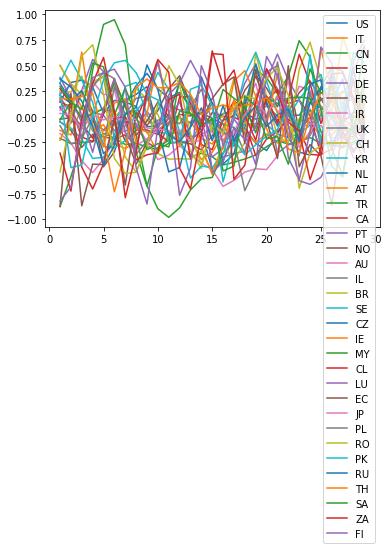

In [350]:
for country in STATIONS:
    a = []
    for days in range(1, 30):
        # print(days, country, ))
        a.append((days, pred_data.TAVG[country].shift(freq=f'{days}d').corr(pred_data.y_residual[country])))
    a = np.array(a)
    # print(a)
    plt.plot(a[:, 0], a[:, 1], label=country)
plt.legend()

In [351]:
pred_data

cases_cum                                                    \
geoId             CN JPG11668     SG      TH      JP      KR        US   
date                                                                     
2020-01-08      59.0      NaN    NaN     NaN     NaN     NaN       NaN   
2020-01-09      59.0      NaN    NaN     NaN     NaN     NaN       NaN   
2020-01-10      59.0      NaN    NaN     NaN     NaN     NaN       NaN   
2020-01-11      59.0      NaN    NaN     NaN     NaN     NaN       NaN   
2020-01-12      59.0      NaN    NaN     NaN     NaN     NaN       NaN   
...              ...      ...    ...     ...     ...     ...       ...   
2020-03-24   81748.0      NaN  509.0   827.0  1128.0  9037.0   46442.0   
2020-03-25   81847.0      NaN  558.0   934.0  1193.0  9137.0   55231.0   
2020-03-26   81968.0      NaN  568.0  1045.0  1268.0  9241.0   69194.0   
2020-03-27   82079.0      NaN  594.0  1136.0  1364.0  9332.0   85991.0   
2020-03-28   82213.0      NaN  732.0  1136.0  1499.0  9478.0  104686.0   

                                     ...  TMAX  TAVG TMIN TMAX  TAVG  TMIN  \
geoId            IT       IR     TW  ...    TH    SA   SA   SA    ZA    ZA   
date                                 ...                                     
2020-01-08      NaN      NaN    NaN  ...   NaN  16.9  NaN  NaN  20.8  18.1   
2020-01-09      NaN      NaN    NaN  ...   NaN  17.9  NaN  NaN  19.9  17.0   
2020-01-10      NaN      NaN    NaN  ...  35.6  18.9  NaN  NaN  19.1   NaN   
2020-01-11      NaN      NaN    NaN  ...   NaN  13.9  NaN  NaN  18.8  15.6   
2020-01-12      NaN      NaN    NaN  ...   NaN  12.6  NaN  NaN  20.8   NaN   
...             ...      ...    ...  ...   ...   ...  ...  ...   ...   ...   
2020-03-24  63927.0  23049.0  195.0  ...  35.5  20.1  NaN  NaN  17.8   NaN   
2020-03-25  69176.0  24811.0  216.0  ...  35.6  21.3  NaN  NaN  21.3  14.5   
2020-03-26  74386.0  27017.0  235.0  ...   NaN   NaN  NaN  NaN   NaN   NaN   
2020-03-27  80539.0  29406.0  252.0  ...   NaN   NaN  NaN  NaN   NaN   NaN   
2020-03-28  86498.0  32332.0  267.0  ...   NaN   NaN  NaN  NaN   NaN   NaN   

            TMAX TAVG TMIN TMAX  
geoId         ZA   FI   FI   FI  
date                             
2020-01-08  24.4  5.7  4.7  7.4  
2020-01-09  23.9  2.7  NaN  7.5  
2020-01-10  22.0 -1.7  NaN  1.6  
2020-01-11   NaN  0.8 -4.0  4.3  
2020-01-12  27.3  5.4  3.2  6.5  
...          ...  ...  ...  ...  
2020-03-24  25.6  3.7  2.2  5.7  
2020-03-25   NaN  5.2  3.5  6.5  
2020-03-26   NaN  NaN  NaN  NaN  
2020-03-27   NaN  NaN  NaN  NaN  
2020-03-28   NaN  NaN  NaN  NaN  

[81 rows x 1050 columns]

In [420]:
def calc_corr(control=False):
    a = []
    # high pass filter
    temp_smoothed = pred_data.TAVG.rolling('7d').mean()
    if control:
        rnd_countries = list(temp_smoothed.columns)
        random.shuffle(rnd_countries)
        rnd_dict = {x: y for x, y in zip(temp_smoothed.columns, rnd_countries)}
        temp_smoothed = temp_smoothed.rename(columns=dict(rnd_dict))
    for days in range(0, 30):
        a.append((days, temp_smoothed.shift(freq=f'{days}d').stack().corr(pred_data.y_residual.stack())))
    a = np.array(a)
    return pd.Series(index=a[:, 0].astype(int), data=a[:, 1], name='corr')

In [420]:
def calc_control_data():
    # TODO: Vectorize this
    NUM_SAMPLES = 5000
    a = []
    for i in range(NUM_SAMPLES):
        if i % 50 == 0:
            print(i, time.asctime(), flush=True)
        a.append(calc_corr(control=True).to_numpy())
    return np.array(a).T

def calc_corr_quantiles():
    q = np.quantile(control_data, q=[0.025, 0.5, 0.975], axis=1)
    return pd.DataFrame({'day': range(q.shape[1]), 'lo': q[0], 'median_': q[1], 'mean_': control_data.mean(axis=1), 'hi': q[2]}).set_index('day')

def quantile_of_score_over_index(series, ctrl):
    s = series.copy()
    for i in s.index:
        s[i] = scipy.stats.percentileofscore(ctrl[i], s[i])/100.0
    return s

def plot_corr(quantiles=False):
    plt.figure(figsize=(20, 10))

    def map_(ser):
        if quantiles:
            return quantile_of_score_over_index(ser, control_data)
        return ser

    corr_quantiles = calc_corr_quantiles()

    a = map_(calc_corr())
    a.plot(label='correlation')
    median_ = map_(corr_quantiles.median_)
    mean_ = map_(corr_quantiles.mean_)
    lo, hi = map_(corr_quantiles.lo), map_(corr_quantiles.hi)
    if quantiles:
        plt.yscale('log')
        # print(a)
    plt.plot(corr_quantiles.index, mean_, '--', label='control median')
    plt.plot(corr_quantiles.index, median_, '--', label='control mean')
    plt.fill_between(corr_quantiles.index, lo, hi, alpha=.2)
    plt.title('Correlation of COVID-19 daily growth factor vs estimate and past daily avg temperature')
    plt.xlabel('Temperature offset (days)')
    plt.legend()

In [421]:
control_data = calc_control_data()

0 Sat Mar 28 21:20:26 2020
50 Sat Mar 28 21:21:00 2020
100 Sat Mar 28 21:21:36 2020
150 Sat Mar 28 21:22:10 2020
200 Sat Mar 28 21:22:45 2020
250 Sat Mar 28 21:23:19 2020
300 Sat Mar 28 21:23:54 2020
350 Sat Mar 28 21:24:28 2020
400 Sat Mar 28 21:25:03 2020
450 Sat Mar 28 21:25:37 2020
500 Sat Mar 28 21:26:12 2020
550 Sat Mar 28 21:26:46 2020
600 Sat Mar 28 21:27:21 2020
650 Sat Mar 28 21:27:55 2020
700 Sat Mar 28 21:28:29 2020
750 Sat Mar 28 21:29:04 2020
800 Sat Mar 28 21:29:38 2020
850 Sat Mar 28 21:30:12 2020
900 Sat Mar 28 21:30:47 2020
950 Sat Mar 28 21:31:21 2020
1000 Sat Mar 28 21:31:57 2020
1050 Sat Mar 28 21:32:32 2020
1100 Sat Mar 28 21:33:06 2020
1150 Sat Mar 28 21:33:41 2020
1200 Sat Mar 28 21:34:15 2020
1250 Sat Mar 28 21:34:50 2020
1300 Sat Mar 28 21:35:24 2020
1350 Sat Mar 28 21:35:59 2020
1400 Sat Mar 28 21:36:34 2020
1450 Sat Mar 28 21:37:08 2020
1500 Sat Mar 28 21:37:43 2020
1550 Sat Mar 28 21:38:17 2020
1600 Sat Mar 28 21:38:52 2020
1650 Sat Mar 28 21:39:27 2020
170

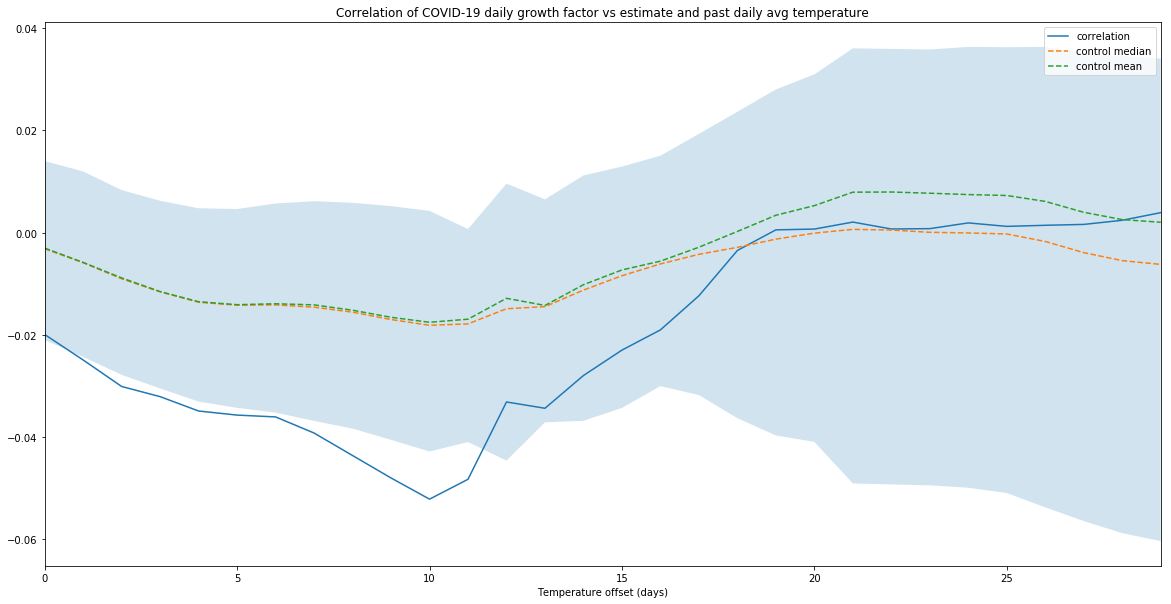

In [422]:
plot_corr(quantiles=False)

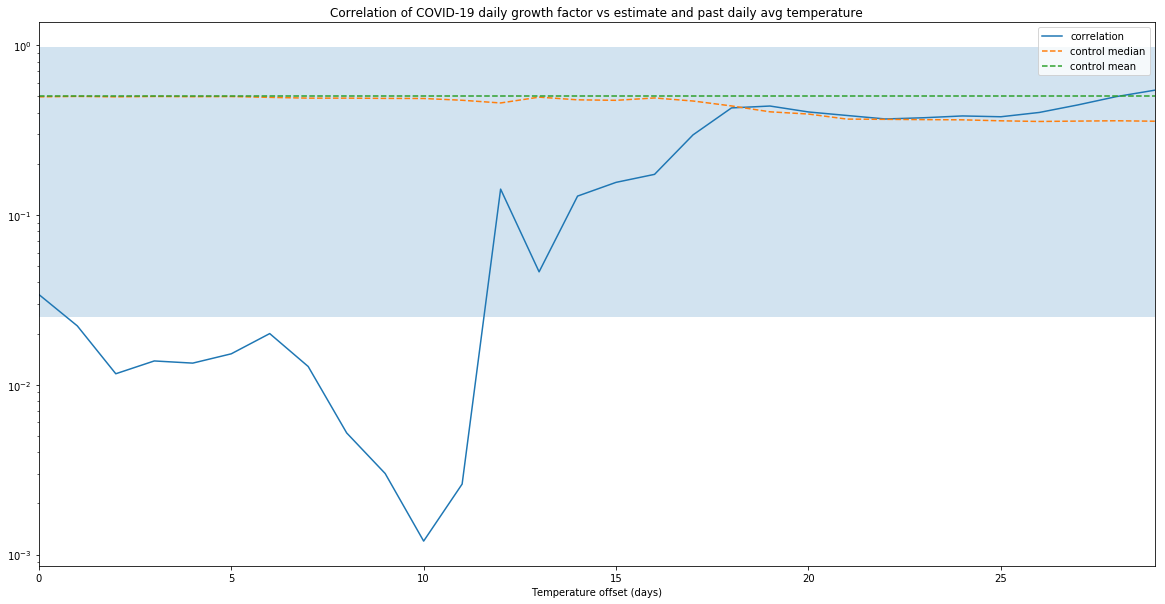

In [423]:
plot_corr(quantiles=True)